# Practical data analytics guide:  Finding explicit polynomial relations in problems with feature interactions and breakpoints
### **Problem statement:**

When studying real-world engineering data, one usually wants to find models that makes sense from a physical point of view, and identify the parameters of the model through data analysis. However, in complex systems (for example electric machines or fluid mechanics), several physical phenomena compete with each other, and complex interactions may occur. 

For illustration purposes, let's consider the following problem:
We have a (fake) dataset of five features $X1, X2, X3, X4$ and $ X5$ and a target value $Y$

The ground-truth model (which is supposed to be unknown) is the following (*note that Y does not depend on X5* : the model should be able to detect this):

$Y = (4*X_1^2 + 2*X_1*X_2 + 0.005*X_2^3)$  for $ X_4 < 200 $

$Y = (2*X_3^2 + 10*X_2*X_3 + 0.01*X_1^3)$  for $ X_4 < 400 $

$Y = (3*X_3^2 + 5*X_2*X_3 + 0.02*X_1^3)$  for $ X_4 < 700 $

$Y = (X_1*X_3 + 4*X_1*X_2 + 0.002 * X_2^3) $  for $ 700 =< X_4 $

In this study, data is generated for X1, X2, X3, X4, X5 and Y is computed with the above model. Gaussian noise is then added around Y in order to be closer to what's happening in reality.

This model combines breakpoints (with X_4) and multi parameter regressions of different degrees. The question is:
**Is it possible to find explicitly this ground-truth model through data analysis and ML methods ?**

**Why it is not that simple:**

Plotting $ Y $ against $ X_i $ or looking at correlations will not be sufficient to grasp the underlying relationships. Moreover, off-the-shelf machine learning algorithms may easily work to make multi-parameters polynomial regressions, or make decision trees that can handle non-polynomial relationship (for instance, dependence on a breakpoint, as in the model above). However, what we are looking for is a **combination** of piecewise polynomial regressions and decision trees.

The **first part** of this study will be a simple case with just one feature $X$ and one target value $Y$, with $Y = f(X)$ where **f is a piecewise polynomial function**. We will use the very useful package [pwlf](https://jekel.me/piecewise_linear_fit_py/index.html) made by Charles Jekel.

The **second part** will be about the **multi-parameter polynomial regression** case (without breakpoints of any kind).

The **third part** will finally tackle the **multi-parameter polynomial regression with breakpoints**.

***Some additionnal comments:***
- In this notebook, some graphs are interactive (generated with plotly), others are not, in order to avoid slowness.
- For the sake of simplicity, we won't be performing standard preprocessing such as scaling, even though it would probably improve performance in some cases. 

## TL;DR (Summary):
To tackle this problem, two possible pathways:
- 1/ **Look systematically for multilinear regressions with polynom and interaction features** (for instance, for two features $X1$ and $X2$, look for $X1^2$ , $X1X2$, $X2^2$, $X1^3$ ...). Scikit learn has efficient built-in methods for this. One challenge can be to identify the right number of parameters / polynom degrees (the usual problem of underfitting vs overfitting). One other challenge is that interactions can be non polynomial (for instance if there are breakpoints: think about the Reynolds number in fluid mechanics). Packages such as **pwlf** can help identify breakpoints in a model.
- 2/ Train a ML model such as XGBoost, regression tree, a neural network and use **explainability methods** to extract the underlying behaviour of the model. In this notebook, we use SHAP (SHapley Additive exPlanations) which is, in 2022, a widely used package for this purpose.

These two methods have their own benefits and drawbacks, and Machine Learning / data analytics is about trying solutions, combining them and iterating. Some problems are more adated to the first method, some to the second, some to a combination of the two.



## Import the libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(0)

# 1. Simple case with breakpoints

In this part, the pwlf package will be used in order to find the piecewise polynomial model behind a "simple" $ Y = f(X) $ relationship

The ground-truth model is:

$Y = (X + 100)*noise$  for $ X < 200 $

$Y = ((X - 200)*2 + 300)*noise$  for $ X < 400 $

$Y = ((X - 400)*1.5 + 700)*noise$  for $ X < 700 $

$Y = (0.02*(X - 700)^2 + 1150)*noise $  for $ 700 =< X < 1000 $

### 1.0 Generating the data

Let's first build the function describe above


In [3]:
def custom_fake_function_1(X):
    if X < 200:
        return X + 100
    elif X < 400:
        return (X-200)*2 + 300
    elif X < 700:
        return((X-400)*1.5 + 700)
    else:
        return (0.02*(X - 700)**2 + 1150) 
        

Then generate and plot the data

Text(0.5, 1.0, 'Y = f(X)')

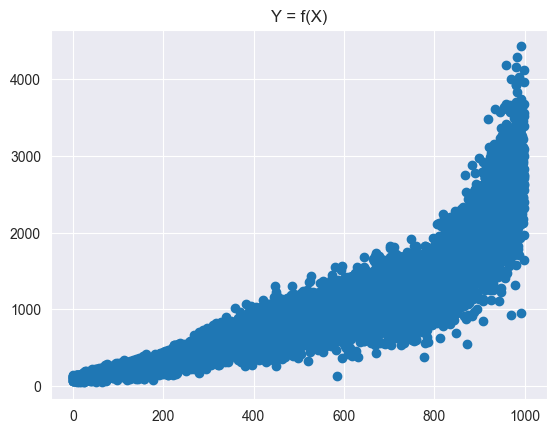

In [4]:

sample_size = 10000

X_1 = np.random.randint(1,1000, size = sample_size)
noise = np.random.normal(1,0.2,sample_size)

#Computing the ground-truth Y
Y_ref = pd.Series(X_1).apply(custom_fake_function_1)
#adding noise
Y = Y_ref*noise

#plot
plt.scatter(X_1, Y)
plt.title("Y = f(X)")


### 1.1 Baseline model

In order to measure the accuracy of future models, we will use the rmse (root mean squared error) of the predictions vs the ground truth Y

**The reference will be the rmse of the ground-truth model: the best possible value given the noise of the data**

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_1,Y,random_state=0, test_size=0.2)
y_val_ref = pd.Series(X_val).apply(custom_fake_function_1)
print(f'The baseline rmse on the test set is : {round(np.sqrt(mean_squared_error(y_val, y_val_ref)),1)}')

The baseline rmse on the test set is : 229.9


### 1.2 Finding the model

In order to find the best model, the following steps will be followed:
- First, different piecewise linear regressions are run, with different hypothesis of number of lines (~number of breakpoints + 1)
- **Crucial point:** the best regression is then obtained by looking at the [*elbow* value](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) of r2 = f(nb_lines) . The elbow value is supposed to be the best trade-off between under-fitting and over-fitting.
- The final regression is then selected and plotted
- The same process is then made for different polynomial degrees (and/or by using logarithmic scales) in order to fine-tune the model

The functions used to perform those steps are located in the utils.py file

#### 1.2.1 Finding linear relationships
Let's use the find_best_model function (which steps are described above) to look for linear relationships. The number of lines will range from 2 to 10.

Computing with 2 lines ...
Computing with 3 lines ...
Computing with 4 lines ...
Computing with 5 lines ...
Computing with 6 lines ...
Computing with 7 lines ...
Computing with 8 lines ...
Computing with 9 lines ...
Computing with 10 lines ...
Knee found: 5.0 lines


Final Model :
Equation number: 1 (for 1.0< x < 206.11)
1.01195678798181*x + 98.4236997361906
Equation number: 2 (for 206.11< x < 384.02)
2.05536125545523*x - 116.63466930982
Equation number: 3 (for 384.02< x < 778.0)
1.48505277976352*x + 102.376473110055
Equation number: 4 (for 778.0< x < 880.03)
4.7626209163735*x - 2447.57153702926
Equation number: 5 (for 880.03< x < 999.0)
9.91568825907827*x - 6982.4162359147
The RMSE of the final model on the test set is: 230.27


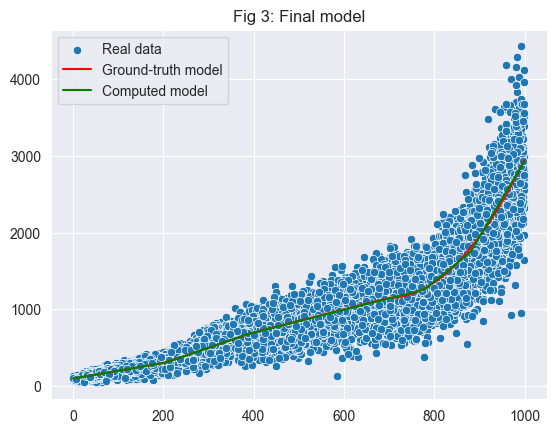

In [6]:
_ , reg_results = find_best_model(X_1,Y,Y_ref,nb_of_lines = range(2,11), display_plot = True, degree = 1)

#### *Comments:*
The best linear model correctly finds the right parameters and breakpoints points, for the piecewise linear part of the equation. Regarding the polynomial part, the model tries to fit linear models to match as closely as possible the real model (see Figure 3 above for the final model).

Note that the final RMSE of the model is 230.3, which is very close to the RMSE of the ground-truth model (229.9).

Let us see now the possible improvement by looking at polynomial regressions


#### 1.2.2 Finding polynomial relationships
The exact same steps as before are followed, this time with a second-degree polynom

Computing with 2 lines ...
Computing with 3 lines ...
Computing with 4 lines ...
Computing with 5 lines ...
Computing with 6 lines ...
Computing with 7 lines ...
Computing with 8 lines ...
Computing with 9 lines ...
Computing with 10 lines ...
Knee found: 3.0 lines


Final Model :
Equation number: 1 (for 1.0< x < 369.0)
0.00254776452585376*x**2 + 0.500263775884292*x + 114.702628407982
Equation number: 2 (for 369.0< x < 695.99)
0.000379041195939969*x**2 + 1.16560112051661*x + 164.490563005741
Equation number: 3 (for 695.99< x < 999.0)
0.0209991819079618*x**2 - 29.6234039811381*x + 11604.886212496
The RMSE of the final model on the test set is: 229.94


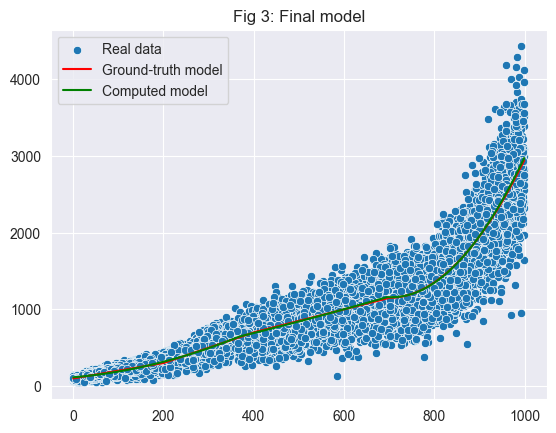

In [7]:
_ , _ = find_best_model(X_1,Y, Y_ref = Y_ref ,nb_of_lines = range(2,11), display_plot = True, degree = 2)

#### 1.2.3 Alternative method: logarithmic regression

As an alternative to the polynomial regression pipeline, it is possible to perform linear regression on $ log(Y) = f(log(X_1)) $ . The slope of the different lines will then correspond to the degree of the polynom (this method is very actually useful in case of non-integer degrees). 

As shown below, the model is very powerful to identify the breakpoints between the linear and non-linear part, and more generally for any change in the polynom degree. The elbow value is in this case perfectly formed.

This method is therefore a straighforward and powerful alternative for more complex unidimensional problems.

Computing with 2 lines ...
Computing with 3 lines ...
Computing with 4 lines ...
Computing with 5 lines ...
Computing with 6 lines ...
Computing with 7 lines ...
Computing with 8 lines ...
Computing with 9 lines ...
Computing with 10 lines ...
Knee found: 3.0 lines


Final Model :
Equation number: 1 (for 0.0< x < 4.78)
0.229156438896185*x + 4.15230841184478
Equation number: 2 (for 4.78< x < 6.7)
1.01315551668297*x + 0.403107835180338
Equation number: 3 (for 6.7< x < 6.91)
3.69457590845906*x - 17.5621141945328
The RMSE of the final model on the test set is: 0.22


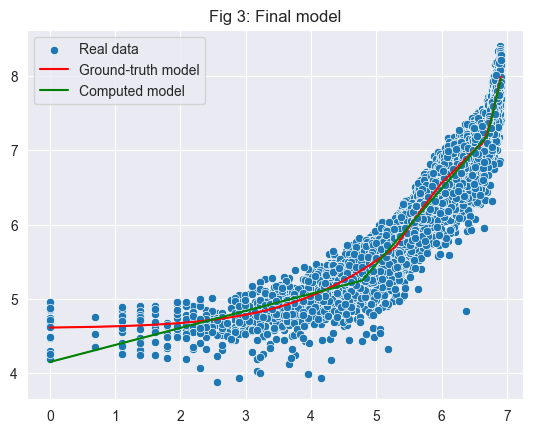

In [8]:
_, _ = find_best_model(np.log(X_1),np.log(Y), Y_ref = np.log(Y_ref), nb_of_lines = range(2,11), display_plot = True, degree = 1)

#### *Comments:*
This time the models correctly finds the breakpoint at X = 700 (696 according to the model), while it fails at finding the linear breakpoints (the model actually adapts by adding a second-order term)

That the final RMSE of the model is 229.9, which is equal to the RMSE of the ground-truth model (229.9) and only slightly better than the linear one (230.3): the rmse metrics actually rewards a good fit in the non-linear part (where absolute values are higher). Moreover, this shows that this model is more prone to overfitting.

### 1.3 Conclusion of the first part 
For piecewise one-dimension polynomial relationships, even with no knowledge of the breakpoints, it is possible to find the right model by:
- Running different piecewise regressions with different hypothesis of number of breakpoints
- Selecting the best model with the elbow method
- Analyzing the results

When using this methodology on different hypothesis of polynom degrees, it is possible to find all the breakpoints with good accuracy. Overall though, the piecewise linear model is often sufficient as breakpoints allow to correctly fit non-linear functions as well.

# 2. Multi-parameter polynomial case (differentiable)

Consider the following equation : 

$Y = (X_1^2 + 2*X_1*X_2 + 0.001*X_2^3 + 0.0008*X_3^3)*noise$

Now, Y depends on $ X_1, X_2, X_3 $ , without any breakpoint (Y is differentiable).
Let's first plot $Y$ against $X_i$ to get an intuition of the model:

### 2.0 Generating the data



In [9]:
sample_size = 10000

X_1 = np.random.randint(1,1000, size = sample_size)
X_2 = np.random.randint(1,1000, size = sample_size)
X_3 = np.random.randint(1,1000, size = sample_size)

noise = np.random.normal(1,0.1,sample_size)

Y = (X_1**2 + 2*X_1*X_2 + 0.001*X_2**3 + 0.0008* X_3**3)*noise


### 2.1 Exploration
Let's first plot the correlation matrix, as well as the pairplot of the matrix

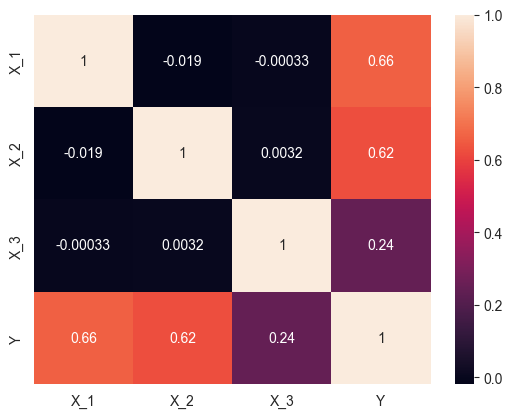

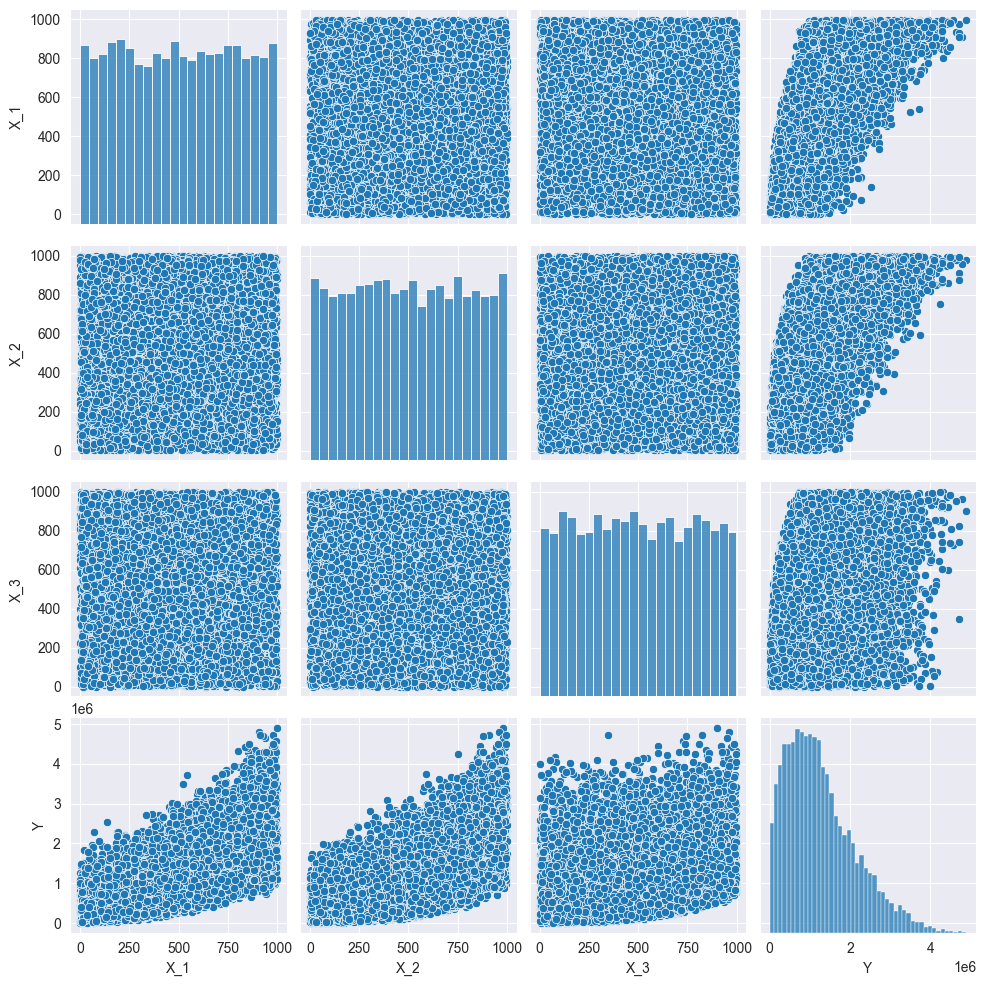

In [11]:
df = pd.concat([pd.Series(X_1),pd.Series(X_2),pd.Series(X_3),pd.Series(Y)],axis = 1)
df.columns = ["X_1","X_2","X_3","Y"]
sns.heatmap(df.corr(), annot = True)
plt.show()
sns.pairplot(df)
plt.show()


From the figures above, we see that Y is positively correlated with X_1, X_2, X_3 (as expected), but simply looking at the pairplot is not enough to understand the underlying relationship. 

If we try to add a third dimension (for instance: $Y = f(X_i)$ with $X_j$ as color panel, we'll get this kind of plot: 

Text(0.5, 1.0, 'Y = f(X_1) with X_2 as color')

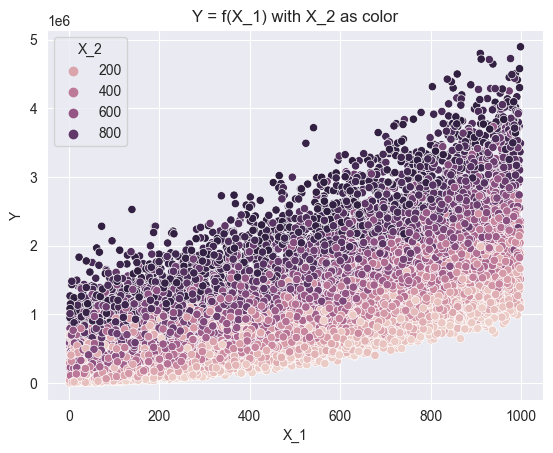

In [12]:
sns.scatterplot(x= "X_1", y = "Y", data = df, hue = "X_2")
plt.title("Y = f(X_1) with X_2 as color")

The plot above shows that Y increases as X_2 and X_1 increases, but the relationship is still not clear (even the degree does not seem visible). 

### 2.2 Naive approach (/!\ Not recommended)
One tempting way to work is to average all the values of Y for each given fixed value of X_1. In practise, we use pd.cut to make categories of X_1, and then we group by each category and plot the result against Y:

Text(0.5, 1.0, 'Average value of Y of each category of X_1 \n Model found : 0.0*1 + 1105.5*X_1_cat + 0.86*X_1_cat^2')

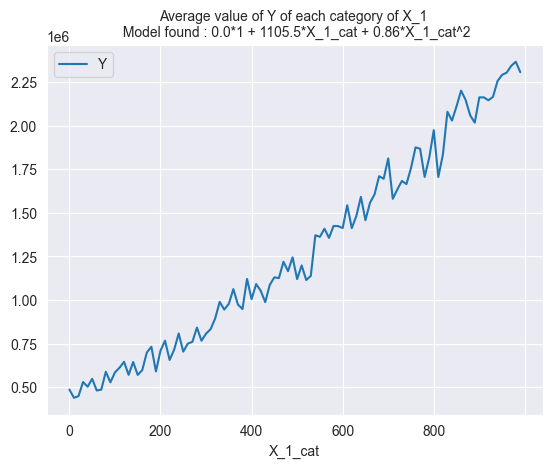

In [13]:
df["X_1_cat"] = pd.cut(df["X_1"], bins = range(0,1001,10), labels = [str(b) for b in range(0,1000,10)] )
df[["X_1_cat","Y"]].groupby(["X_1_cat"]).mean().plot()
_, c , model = multi_linear_regression(polynomial_transform(df[["X_1_cat"]], max_degree = 2), df[["Y"]], display_plot = False)
out = print_model(model.coef_[0], c, nb_decimals = 2)
plt.title(f"Average value of Y of each category of X_1 \n {out}", fontsize=10)


While the plot and the corresponding model correctly find the polynomial relationship between $Y$ and $X_1$, **they fail to correctly identify its parameters**, as the identified ones depend on the distribution of $X_2$ (and $X_3$): $X_2$ has an average value of $500$ on the dataset so the models finds a slope close to $ 2*500 = 1000 $ . If $X_2$ and $X_3$ were not drawn randomly (which is often the case in practise), those parameters would have been different.

As a result, while this method is tempting, easy-to-understand and fast, **it can lead to flawed modelling**. 

### 2.3 Multilinear regression on polynomial features
It is best to follow a more systematic approach, which is done in the "make_polynomial_regressions" function below:
- First generate polynomial and interaction features with Scikit learn's [Polynomial Features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), given a certain maximum degree parameter (max_degree)
- Then run a first multilinear regression model on the new features
- Select the k most important parameters (k varies) using Scikit learn's [Permutation Importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
- With the selected features and the max_degree parameter, run a new multilinear regression model, and evaluate its training error and test error
- Plot the resulting training / test error as a function of the maximum degree and number of parameters, and find the best model: this model should have a low training error and low overfitting (test error compared to training error)

*Note on the permutation importance (from scikit learn documentation) : "Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. (...) Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model."*

This effect can be particularly strong for overfitted models. Therefore only consider the best features for the model (carefully) selected in the end !

The rmse_result dataframe contains the results of the final model:


In [14]:
rmse_results = make_polynomial_regressions(df[["X_1","X_2","X_3"]], Y, 4)

Finding model with 3 parameters and degree = 2
Model found : 0.74659*X_3^2 + 3.37578*X_1 X_2 + 0.27092*X_2^2
--------------------------------------------------
Finding model with 4 parameters and degree = 2
Model found : 1.09281*X_1^2 + 1.00724*X_2^2 + 1.82432*X_1 X_2 + 0.75405*X_3^2
--------------------------------------------------
Finding model with 5 parameters and degree = 2
Model found : -573.43373*X_2 + 1.01599*X_1^2 + 1.46947*X_2^2 + 1.9867*X_1 X_2 + 0.75369*X_3^2
--------------------------------------------------
Finding model with 6 parameters and degree = 2
Model found : -504.97745*X_3 + -572.18339*X_2 + 1.01413*X_1^2 + 1.4701*X_2^2 + 1.99118*X_1 X_2 + 1.22745*X_3^2
--------------------------------------------------
Finding model with 7 parameters and degree = 2
Model found : -29.95397*X_1 + -505.30619*X_3 + -577.35586*X_2 + 1.03775*X_1^2 + 1.4704*X_2^2 + 2.00094*X_1 X_2 + 1.22782*X_3^2
--------------------------------------------------
Finding model with 3 parameters and de

Let's plot the results : 

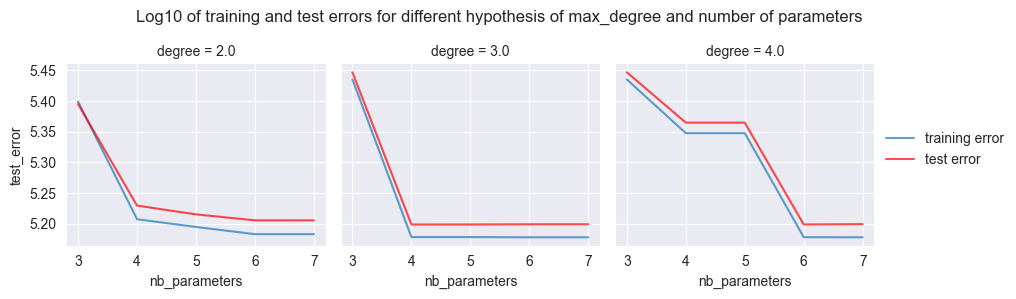

In [15]:
plot_pol_reg_results(rmse_results)

In this case, there is a very clear elbow value with degree = 3 and nb_parameters = 4. The corresponding model is $0.00081*X_3^3 + 0.00099*X_2^3 + 1.01324*X_1^2 + 1.99633*X_1 X_2$, while the ground truth one is $X_1^2 + 2*X_1*X_2 + 0.001*X_2^3 + 0.0008*X_3^3$ . In spite of the noise, all the parameters are correctly identified, with an error of less than 2% ! 

### 2.4 Conclusion of the second part 

For multi-dimensional polynomial relationships, one effetive strategy to find the right model is:
- Running different multilinear regressions on polynomial features with different hypothesis of polynom degree and number of parameters. Scikit learn's permutation importance function helps finding the k most impactful features
- Selecting the best model by plotting the results (it is also possible to use the elbow model in case of a doubt)
- Analyzing the results

In the first part, we described a methodology to find breakpoints in a one-dimensional problem. In the second part, we described a way to find a polynomial model in a multi-dimensional problem. Let's now mix the two methods to solve our initial problem !

# 3. Third and final part: Piece-wise multi-parameter polynomial case
In this part we will go back to our initial case, and describe the different steps to identify the right parameters of the model

### 3.0 Generating the data
As a reminder the model is the following:

$Y = (4*X_1^2 + 2*X_1*X_2 + 0.005*X_2^3)*noise$  for $ X_4 < 200 $

$Y = (2*X_3^2 + 10*X_2*X_3 + 0.01*X_1^3)*noise$  for $ X_4 < 400 $

$Y = (3*X_3^2 + 5*X_2*X_3 + 0.02*X_1^3)*noise$  for $ X_4 < 700 $

$Y = (0.5*X_1*X_3 + 2*X_1*X_2 + 0.001 * X_2^3)*noise $  for $ 700 =< X_4 $

In [16]:
def custom_fake_function_2(X_1, X_2, X_3, X_4):
    if X_4 < 200:
        return 4*X_1**2 + 2*X_1*X_2 + 0.005 * X_3**3
    elif X_4 < 400:
        return 2*X_3**2 + 10*X_2*X_3 + 0.01 * X_1**3
    elif X_4 < 700:
        return 3*X_3**2 + 5*X_2*X_3 + 0.02 * X_1**3
    else:
        return (X_1*X_3 + 4*X_1*X_2 + 0.002 * X_2**3) 

In [17]:
sample_size = 10000

X_1 = np.random.randint(1,1000, size = sample_size)
X_2 = np.random.randint(1,1000, size = sample_size)
X_3 = np.random.randint(1,1000, size = sample_size)
X_4 = np.random.randint(1,1000, size = sample_size)
X_5 = np.random.randint(1,1000, size = sample_size)

noise = np.random.normal(1,0.1,sample_size)

df_X = pd.concat([pd.Series(X_1),pd.Series(X_2),pd.Series(X_3),pd.Series(X_4),pd.Series(X_5)], axis = 1)
df_X.columns = ["X_1","X_2","X_3","X_4","X_5"]
                 
Y_ref = df_X.apply(lambda x : custom_fake_function_2(x['X_1'], x['X_2'],x['X_3'],x['X_4']), axis=1)
Y = Y_ref*noise 

Let's define a baseline model as before, to determine the best achievable rmse

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_X,Y,random_state=0, test_size=0.2)
y_val_ref = X_val.apply(lambda x : custom_fake_function_2(x['X_1'], x['X_2'],x['X_3'],x['X_4']), axis=1)
print(f'The baseline rmse on the test set is : {round(np.sqrt(mean_squared_error(y_val, y_val_ref)),1)}')

The baseline rmse on the test set is : 583098.8


### 3.1 Exploration
Let's first plot the correlation matrix along with the pairplot, to try and identify the right model features

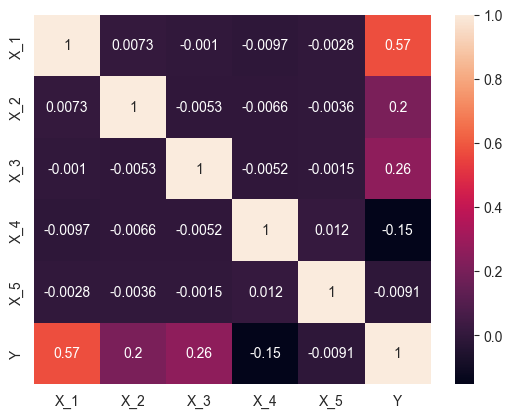

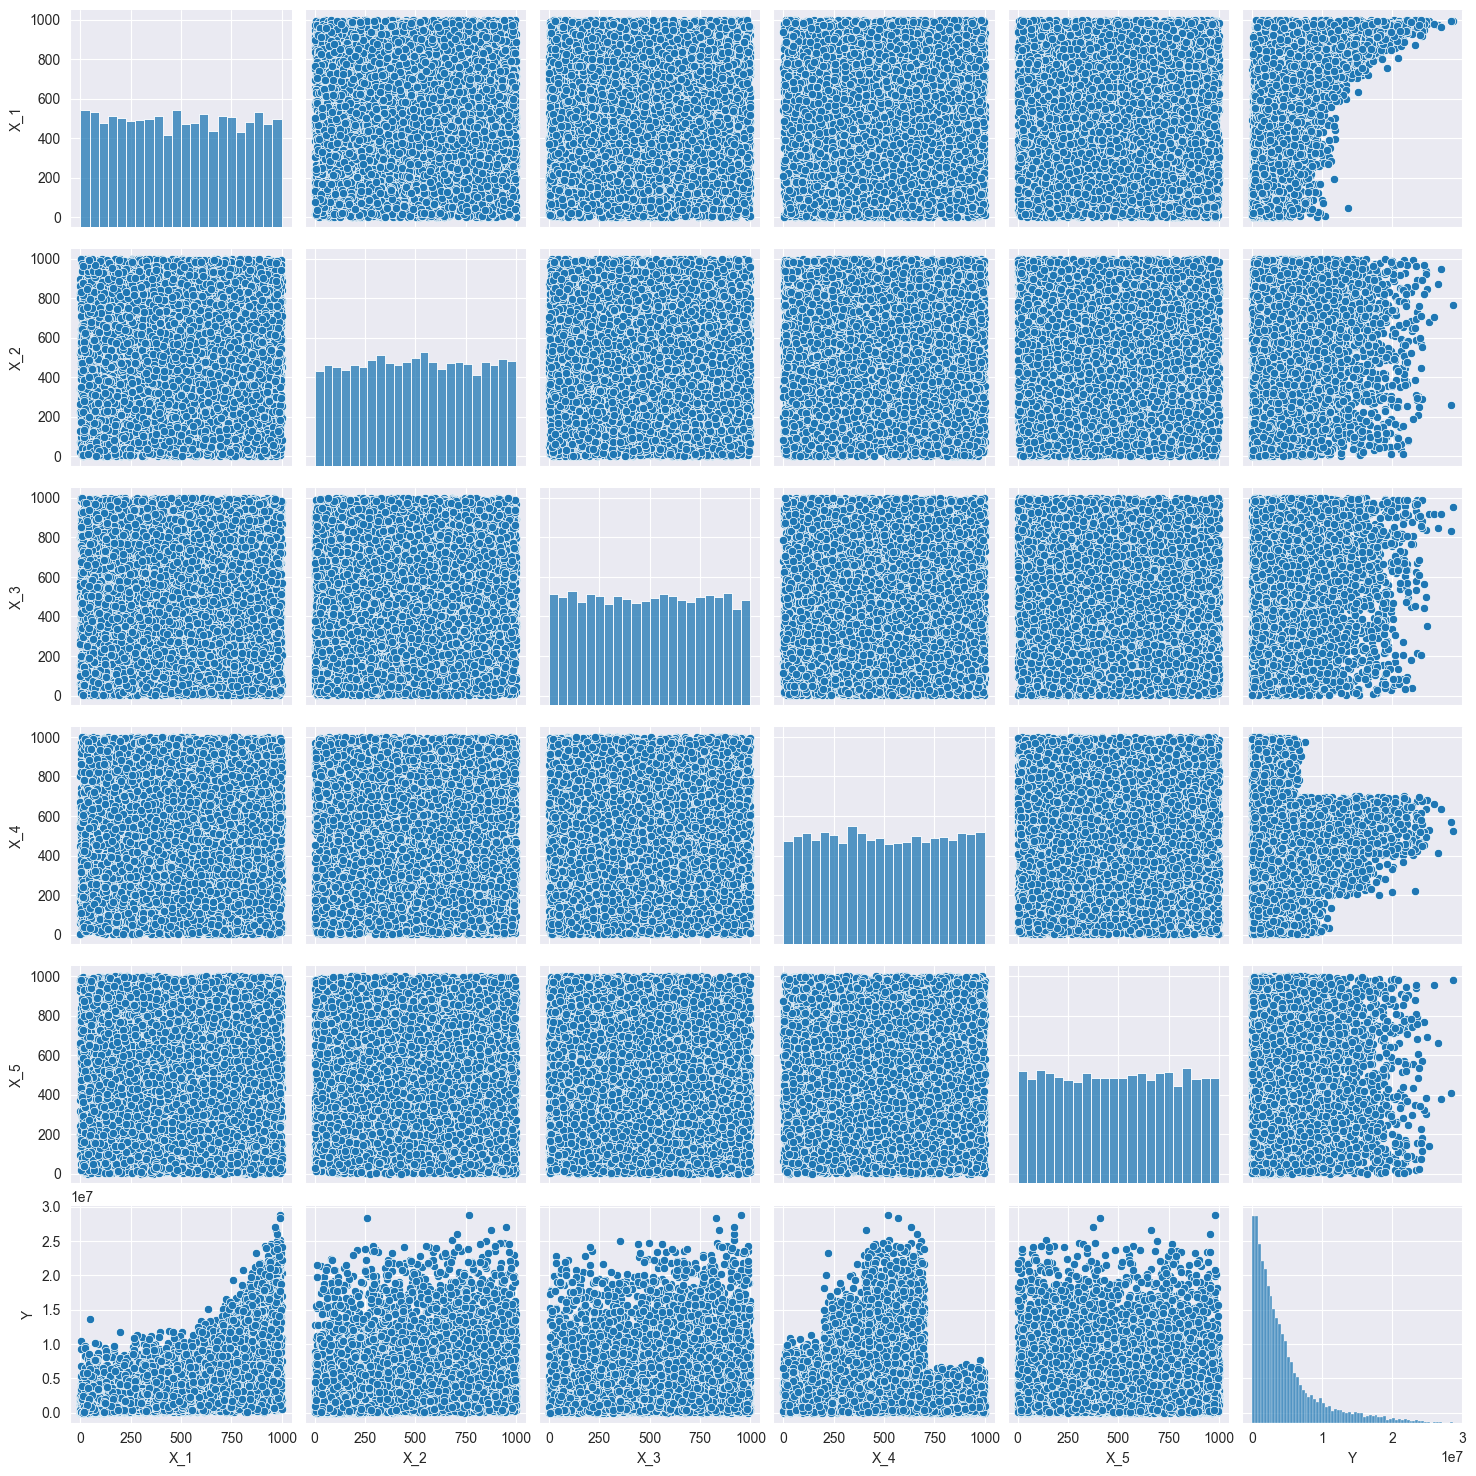

In [19]:
df = pd.concat([df_X, Y],axis = 1)
df.columns = ["X_1","X_2","X_3","X_4","X_5", "Y"]
sns.heatmap(df.corr(), annot = True)
plt.show()
sns.pairplot(df)
plt.show()


At this point, even though some trends appear (for instance in $Y = f(X_i)$), it is almost impossible to correctly identify the correct relevant features or interactions (remember that the close-to-zero correlation between $X_5$ and $Y$ does not mean that we should remove $X_5$ from the model at this point. For instance, the correlation between $Y$ and $X_4$ is "only" -0.15, while we already know that $X_4$ plays a big role in the model).

### 3.2 Finding relevant features and breakpoints

The first (and most important) step is to identify correctly the breakpoints. Once it will be done, one will just have to run the methodology described in the second part of this study to each segment.

The methodology will be the following:
- Train a relevant ML model (in this case: XGBoost, but it could work with other models as well, such as a Neural Net) to fit the data. Note that it is not necessary to make polynomial or interaction features, unless there is a reason to believe that breakpoints depend on the combination of several features. The model is able to understand the relationship between the features and the target, but at this point it will fail to directly tell us where the breakpoints are, and the nature of the relationship. So we need to make the model speak !
- When the model is fitted (no need for extensive hyperparameter tuning in this case), we will explore two paths: either run a permutation importance analysis, or use SHAP to explain the model and find the relevant interactions
- When interactions are correctly identified, it is possible to make more relevant plots (manually or with SHAP), it will then be possible to see the possible breakpoints.
- Once breakpoints have been found, use the methodology from part 2 for each segment of the function.



#### 3.2.1 Fitting a gradient boost regressor

In [20]:
from xgboost import XGBRegressor

X_train, X_val, y_train, y_val = train_test_split(df_X,Y,random_state=0)
regressor_new = XGBRegressor(random_state=400,
                              max_depth = 5,
                              eta = 0.5,
                              booster = "gbtree",
                              gamma = 0.7,
                              subsample = 0.8,
                              colsample_bytree = 0.7,
                              colsample_bylevel = 0.8,
                              colsample_bynode= 0.6)
regressor_new.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.6, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.5,
             eval_metric=None, gamma=0.7, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=400,
             reg_alpha=0, ...)

In [21]:
y_pred_val = regressor_new.predict(X_val)
print(f'The model rmse on the test set is : {round(np.sqrt(mean_squared_error(y_val, y_pred_val)),1)}')

The model rmse on the test set is : 1037702.7


#### 3.2.2 Assessing feature importance using scikit learn

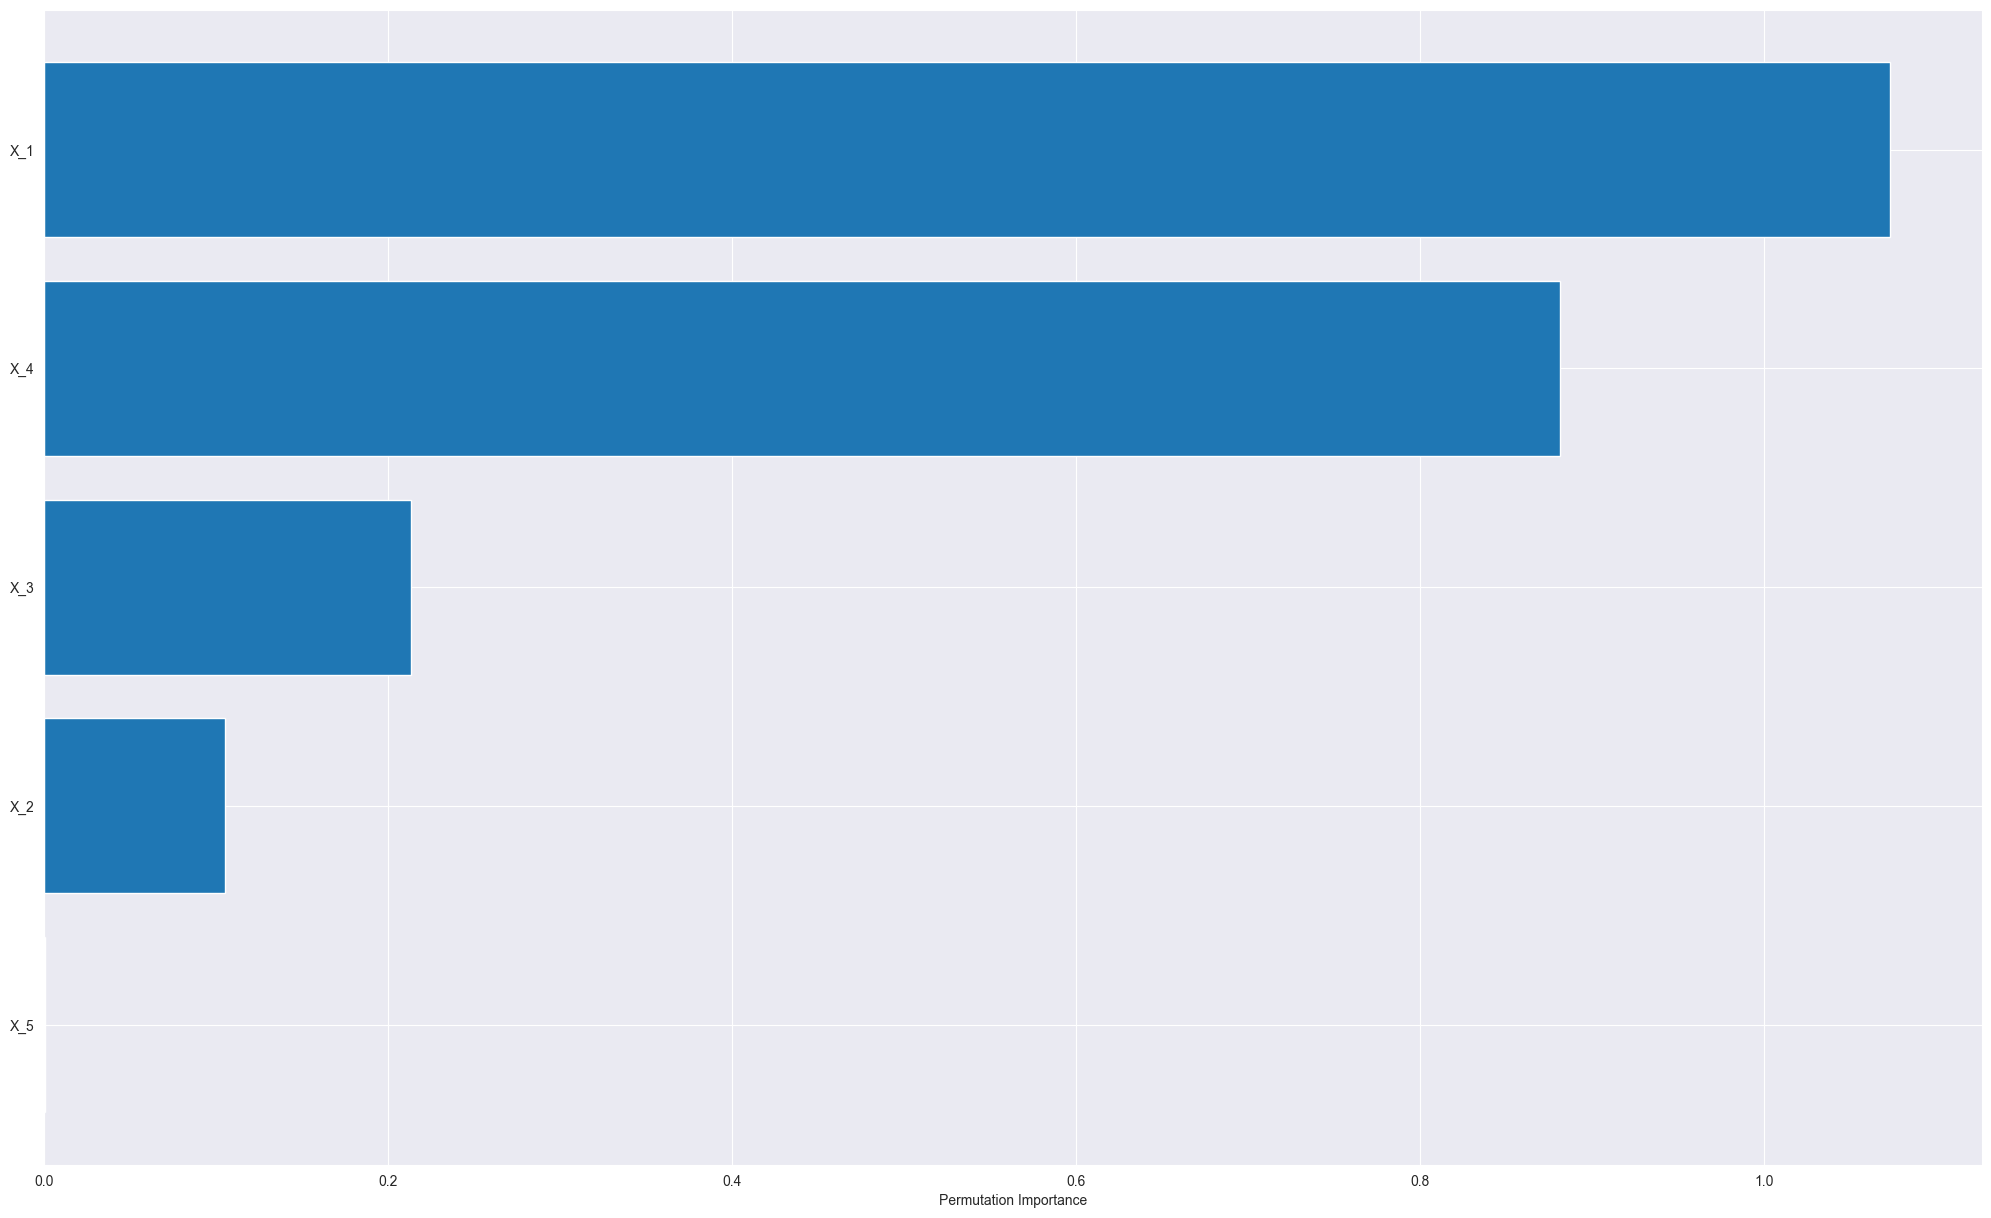

In [22]:
perm_importance = permutation_importance(regressor_new, X_val, y_val,
                           n_repeats=30,
                           random_state=0)

to_bar = pd.DataFrame(perm_importance.importances_mean, index = [str(f) for f in df_X.columns]).sort_values(by = 0, ascending = True)
plt.figure(figsize = (25,15))
plt.barh(to_bar.index, to_bar[0])
plt.xlabel("Permutation Importance")
plt.show()

Scikit learn shows that X_5 does not have any importance in the model (which is correct) and can therefore be removed. However, while it shows that X_4 has a big importance (which the correlation matrix did not show), it does not have the ability to identify the interactions between features.

#### 3.2.3 Assessing feature importance and interactions using SHAP

SHAP is a well-known library used to explain the output of machine learning models. In particular, it can be used to explain decision trees, neural networks, or more simply linear models.

SHAP is considered as more reliable and complete than scikit learn's or XGB built-in feature importance methods

In [23]:
import shap
explainer = shap.TreeExplainer(regressor_new)
shap_values = explainer.shap_values(X_val)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


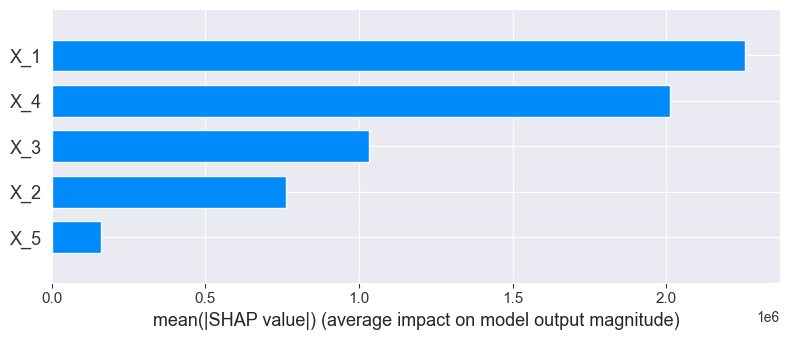

In [24]:
shap.summary_plot(shap_values, X_val, plot_type="bar")

Compared to scikit learn, SHAP puts relatively more importance on X_3, X_2 ... and X_5, than scikit learn. While it is probably correct for X_3 and X_2, it is not for X_5 (though it is common for a XGBRegressor to be slightly overfitted, especially without any kind of hyperparameter tuning: SHAP is only doing its job to identify that !). 

What's more interesting in SHAP is the "dependence plot" function, which shows the interaction between each feature and its most dependent counterpart. The way to read the below plots is: 
- Y-axis value is the "SHAP value" : the importance of each feature on the output
- X-axis value is the feature
- Color palette is the impact of the feature which has the most interaction with the X-axis featuer

**The more the interaction is important, the more the Y values will be spread vertically**

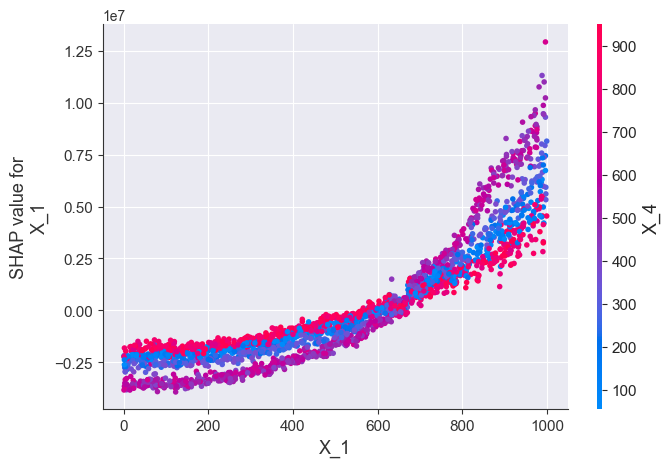

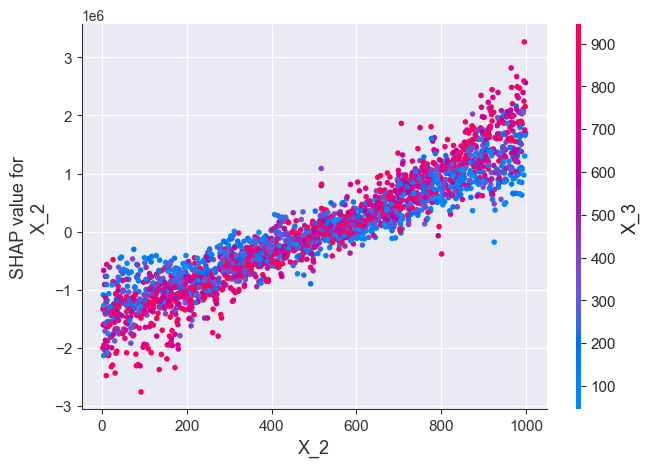

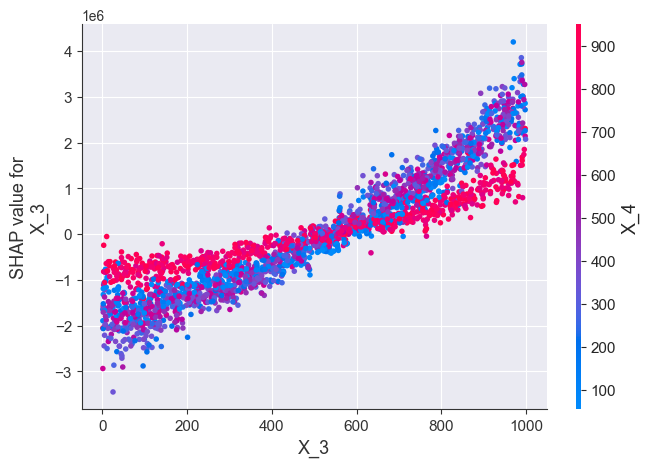

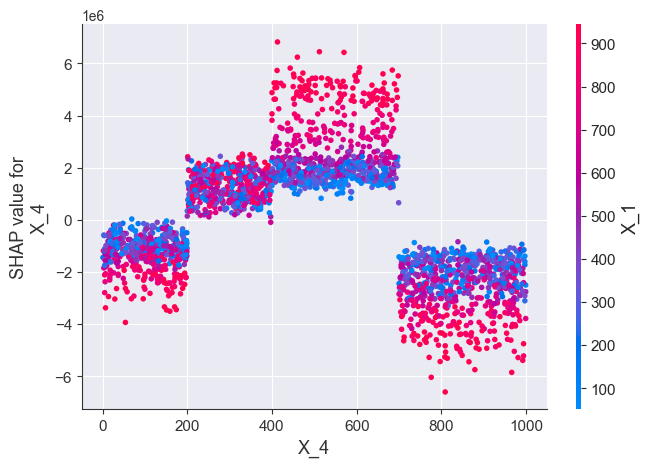

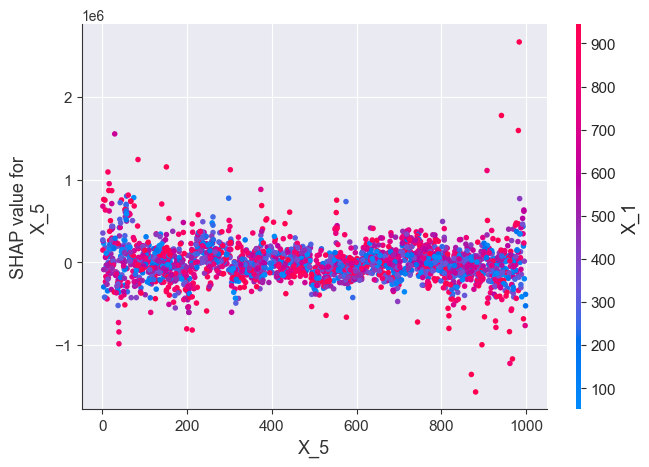

In [25]:
for name in df_X.columns:
    shap.dependence_plot(name, shap_values, X_val, display_features=df_X)

SHAP correctly represents most of the interactions (especially the effect of X_4) and clearly shows the breakpoints on X_4. We will however pretend that the breakpoint at $X_4 = 400$ was not identified. 

It can be helpful to correctly represent all interactions (as one feature may interact with several ones). It is possible to do it under the form of a matrix, which we will plot as a heatmap below. On the matrix, the diagonal will quantify the overall feature importance, while the other values will quantify the interaction effect. For better visualisation, all those values are normalised and put in absolute values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<AxesSubplot: >

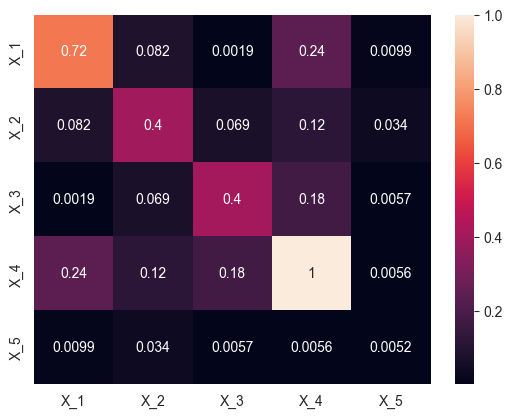

In [26]:
shap_interaction_values = explainer.shap_interaction_values(X_val)
sns.heatmap(np.abs(shap_interaction_values[0].round(2))/np.abs(shap_interaction_values[0]).max(), annot = True, xticklabels=df_X.columns, yticklabels=df_X.columns)

At this point the model has correctly detected that $X_5$ is not relevant, according to all metrics. It is possible to drop it, even though we will be keeping it for illustration purposes. Moreover, the dependency of $X_1 X_2 X_3$ with $X_4$ is clearly visible.
Let's finally run our regressions on the two identified breakpoints ($X_4 = 200$ and $X_4 = 700$) : 

Finding model with 2 parameters and degree = 2
Model found : 5.07338*X_1^2 + 4.84945*X_3^2
--------------------------------------------------
Finding model with 3 parameters and degree = 2
Model found : -2786.1381*X_3 + 5.05132*X_1^2 + 7.45909*X_3^2
--------------------------------------------------
Finding model with 4 parameters and degree = 2
Model found : 2.08778*X_1 X_2 + -3156.24291*X_3 + 4.01549*X_1^2 + 7.77176*X_3^2
--------------------------------------------------
Finding model with 5 parameters and degree = 2
Model found : -200.78144*X_1 + 2.10434*X_1 X_2 + -3151.62308*X_3 + 4.19609*X_1^2 + 7.76828*X_3^2
--------------------------------------------------
Finding model with 6 parameters and degree = 2
Model found : 0.40353*X_1 X_3 + 2.09325*X_1 X_2 + -3358.33806*X_3 + 7.77066*X_3^2 + -389.56979*X_1 + 4.18873*X_1^2
--------------------------------------------------
Finding model with 7 parameters and degree = 2
Model found : 0.14212*X_2 X_3 + 0.41119*X_1 X_3 + 1.98953*X_1 X_2 

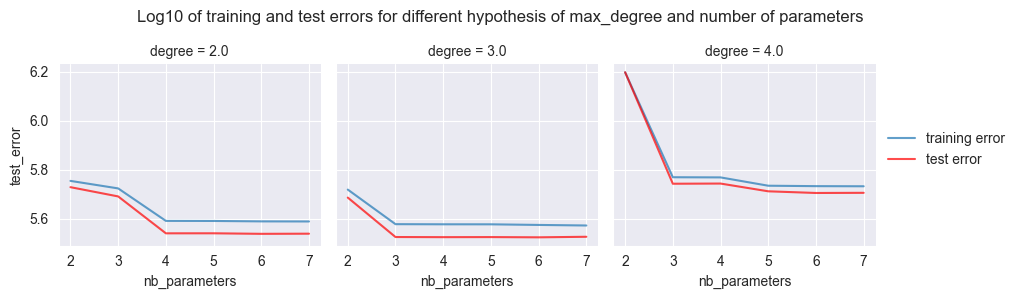

In [27]:
plot_pol_reg_results(make_polynomial_regressions(df.loc[df.X_4<200,["X_1","X_2","X_3","X_4"]], df.loc[df.X_4<200,"Y"], max_degree = 4, parameter_range = range(2,8)), log = True)

Degree = 4 is clearly inferior; let's zoom on degree = 2 or 3:

Finding model with 2 parameters and degree = 2
Model found : 5.07338*X_1^2 + 4.84945*X_3^2
--------------------------------------------------
Finding model with 3 parameters and degree = 2
Model found : -2786.1381*X_3 + 5.05132*X_1^2 + 7.45909*X_3^2
--------------------------------------------------
Finding model with 4 parameters and degree = 2
Model found : 2.08778*X_1 X_2 + -3156.24291*X_3 + 4.01549*X_1^2 + 7.77176*X_3^2
--------------------------------------------------
Finding model with 5 parameters and degree = 2
Model found : -200.78144*X_1 + 2.10434*X_1 X_2 + -3151.62308*X_3 + 4.19609*X_1^2 + 7.76828*X_3^2
--------------------------------------------------
Finding model with 6 parameters and degree = 2
Model found : 0.40353*X_1 X_3 + 2.09325*X_1 X_2 + -3358.33806*X_3 + 7.77066*X_3^2 + -389.56979*X_1 + 4.18873*X_1^2
--------------------------------------------------
Finding model with 7 parameters and degree = 2
Model found : 0.14212*X_2 X_3 + 0.41119*X_1 X_3 + 1.98953*X_1 X_2 

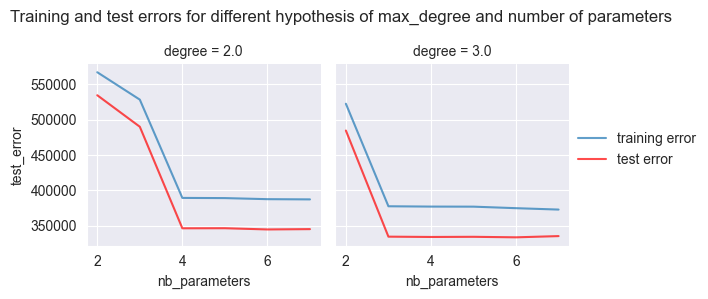

In [28]:
plot_pol_reg_results(make_polynomial_regressions(df.loc[df.X_4<200,["X_1","X_2","X_3","X_4"]], df.loc[df.X_4<200,"Y"], max_degree = 3, parameter_range = range(2,8)), log = False)

Degree = 3 and nb_parameters = 3 seem superior with lower overfitting. The corresponding model is $2.00038*X_1 X_2 + 0.00506*X_3^3 + 3.95054*X_1^2$ , to compare with the ground-truth $4*X_1^2 + 2*X_1*X_2 + 0.005*X_2^3$ . The parameters are correctly found with an error of ~1% . The same methodology can apply for the rest of the breakpoints.